# Node Embedding Techniques

## Introduction

This notebook introduces some node embedding techniques, which are used to represent nodes in a graph as vectors in a low-dimensional space. The goal is to learn a mapping from the original node features to a low-dimensional space, such that the learned representations can be used in downstream tasks, such as node classification, link prediction, and community detection.

Let's first define a simple graph and generate node features for each node.


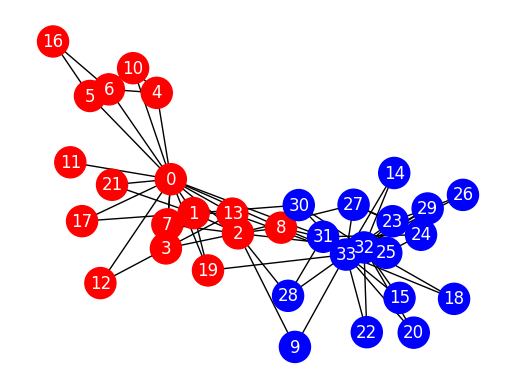

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the Karate Club graph
G = nx.karate_club_graph()

# Get the target (club) for each node
target = [G.nodes[node]['club'] == 'Mr. Hi' for node in G.nodes()]

# Map the target to colors
colors = ['red' if t else 'blue' for t in target]

# Draw the graph
pos = nx.spring_layout(G)
fig, ax = plt.subplots()
nx.draw(G, pos, node_color=colors, with_labels=True, ax=ax, node_size=500, font_color='white')



NodeDataView({0: {'club': 'Mr. Hi'}, 1: {'club': 'Mr. Hi'}, 2: {'club': 'Mr. Hi'}, 3: {'club': 'Mr. Hi'}, 4: {'club': 'Mr. Hi'}, 5: {'club': 'Mr. Hi'}, 6: {'club': 'Mr. Hi'}, 7: {'club': 'Mr. Hi'}, 8: {'club': 'Mr. Hi'}, 9: {'club': 'Officer'}, 10: {'club': 'Mr. Hi'}, 11: {'club': 'Mr. Hi'}, 12: {'club': 'Mr. Hi'}, 13: {'club': 'Mr. Hi'}, 14: {'club': 'Officer'}, 15: {'club': 'Officer'}, 16: {'club': 'Mr. Hi'}, 17: {'club': 'Mr. Hi'}, 18: {'club': 'Officer'}, 19: {'club': 'Mr. Hi'}, 20: {'club': 'Officer'}, 21: {'club': 'Mr. Hi'}, 22: {'club': 'Officer'}, 23: {'club': 'Officer'}, 24: {'club': 'Officer'}, 25: {'club': 'Officer'}, 26: {'club': 'Officer'}, 27: {'club': 'Officer'}, 28: {'club': 'Officer'}, 29: {'club': 'Officer'}, 30: {'club': 'Officer'}, 31: {'club': 'Officer'}, 32: {'club': 'Officer'}, 33: {'club': 'Officer'}})

## Feature engineering

We will first use the networkx library to create a vector associated to each encoding its degree and different measures of centrality.

In [116]:
import numpy as np
from sklearn.decomposition import PCA

def compute_node_degree(G):
    return dict(G.degree())

def compute_betweenness_centrality(G):
    return nx.betweenness_centrality(G)

def compute_closeness_centrality(G):
    return nx.closeness_centrality(G)

def compute_eigenvector_centrality(G):
    return nx.eigenvector_centrality(G)

# Compute the centrality measures
node_degree = compute_node_degree(G)
node_betweenness_centrality = compute_betweenness_centrality(G)
node_closeness_centrality = compute_closeness_centrality(G)
node_eigenvector_centrality = compute_eigenvector_centrality(G)


Plot the graph with node' size proportionnal to each feature. Are the sizes correct to your intuition ? 

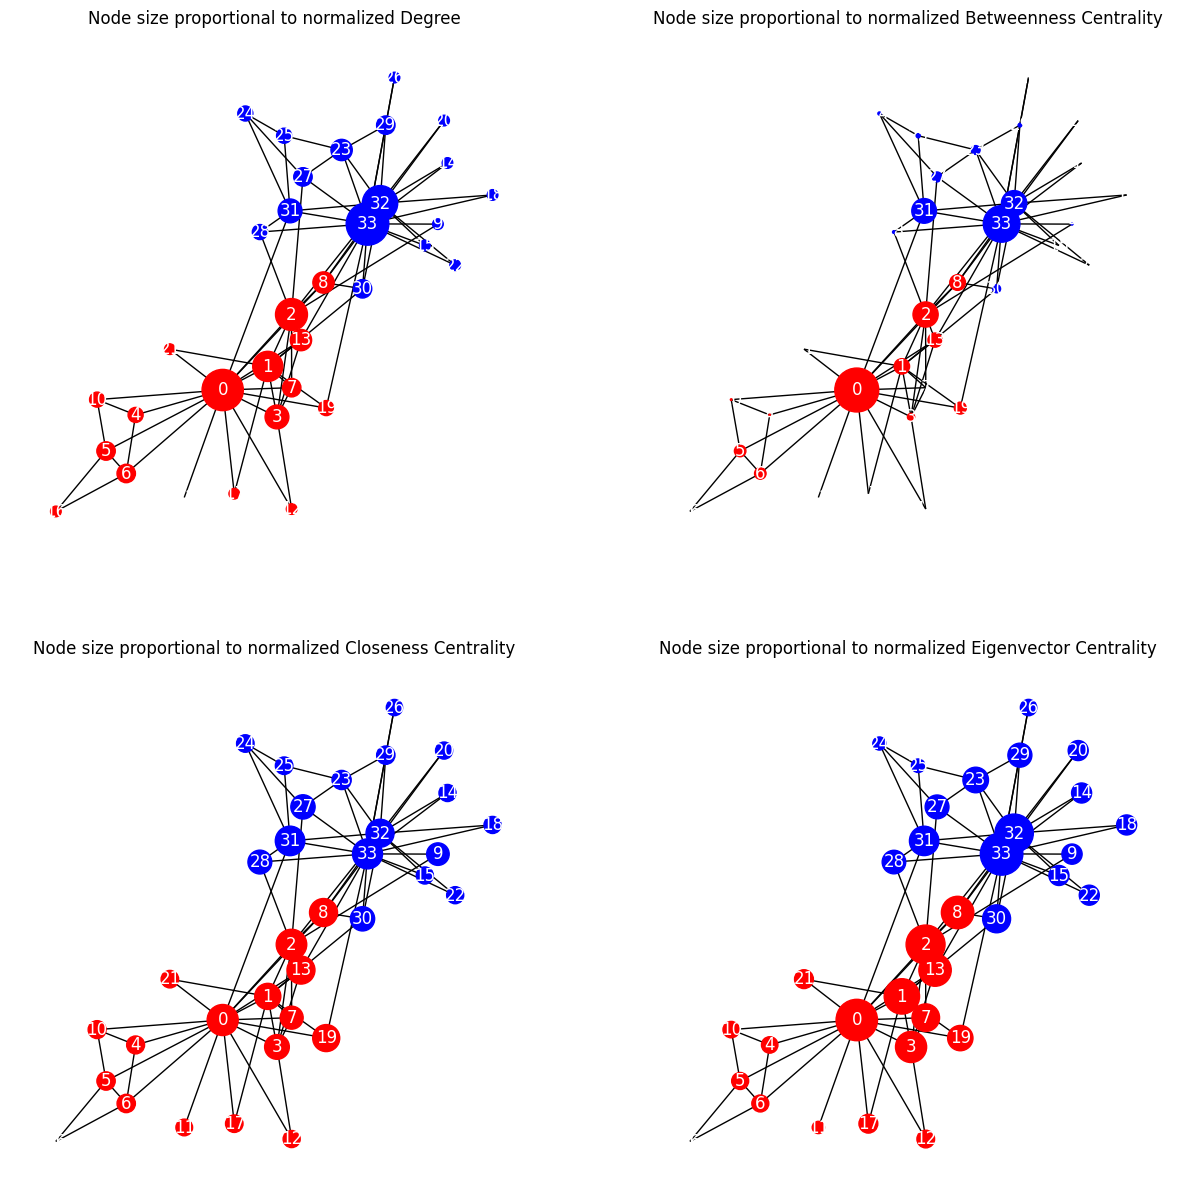

In [117]:


# Normalize the features
node_features = [[node_degree[node],
                node_betweenness_centrality[node],
                node_closeness_centrality[node],
                node_eigenvector_centrality[node]] for node in G.nodes()]
node_features = np.array(node_features)

normalized_node_features_matrix = (node_features - np.min(node_features, axis=0))/np.max(node_features,axis=0)
# Draw the graph with node size proportional to each feature
features = ['Degree', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for ax, feature, i in zip(axes, features, range(normalized_node_features_matrix.shape[1])):
    normalized_node_feature_values = normalized_node_features_matrix[:, i]
    node_size = [1000 * normalized_value for normalized_value in normalized_node_feature_values]
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=node_size, font_color='white', ax=ax)
    ax.set_title(f'Node size proportional to normalized {feature}')

plt.show()


## Spectral Embedding

Another approach to compute a node embedding is to use its spectral representation obtained from the Laplacian, as seen in previous classes.

Compute the embedding of each node, and plot the graph with node's coordinates corresponding to the two first eigenvectors of the Laplacian. What do you observe ? 

Try to do it by yourself and using networkx library

In [118]:
laplacian = nx.laplacian_matrix(G, weight=None).todense()

w,v = np.linalg.eigh(laplacian)
print(w)
spectral_pos = v[:,1:3]

# Plot the 2D embedding
plt.figure()
nx.draw(G, pos=spectral_pos, node_color=colors, with_labels=True, node_size=500, font_color='white')
plt.title('Spectral Embedding of the Karate Club Graph')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


[-2.36705109e-15  4.68525227e-01  9.09247664e-01  1.12501072e+00
  1.25940411e+00  1.59928308e+00  1.76189862e+00  1.82605521e+00
  1.95505045e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  2.48709173e+00  2.74915718e+00
  3.01396297e+00  3.24206748e+00  3.37615409e+00  3.38196601e+00
  3.47218740e+00  4.27587682e+00  4.48000767e+00  4.58079267e+00
  5.37859508e+00  5.61803399e+00  6.33159222e+00  6.51554463e+00
  6.99619703e+00  9.77724095e+00  1.09210675e+01  1.33061223e+01
  1.70551712e+01  1.81366960e+01]


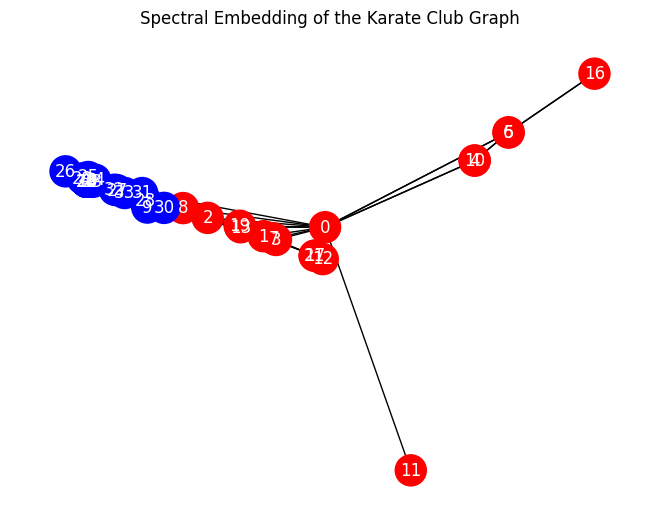

In [119]:
# Compute the spectral embedding
spectral_pos = nx.spectral_layout(G, dim=2,weight=None)

# Plot the 2D embedding
plt.figure()
nx.draw(G, pos=spectral_pos, node_color=colors, with_labels=True, node_size=500, font_color='white')
plt.title('Spectral Embedding of the Karate Club Graph')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


## DeepWalk

As seen in the lecture, DeepWalk is a method that learns a node embedding by treating random walks on the graph as sentences. The Word2Vec model is then used to learn the embedding of each node.

First, let's use the DeepWalk implementation from the karateclub library to compute the node embeddings. Then, plot the graph with node's coordinates corresponding to the two first dimensions of the DeepWalk embedding. 

In [120]:
from karateclub import DeepWalk

dw = DeepWalk(dimensions=32)
dw.fit(G)
dw_embedding = dw.get_embedding()

plt.scatter(dw_embedding[:,0],dw_embedding[:,1],c=colors)

Now, we will implement ourselves the DeepWalk algorithm.

1. Generate random walks on the graph : complete the function random_walk so as it performs a random walk of length `length` starting from node `start`.

2. Train a skip gram model as in Word2Vec on the random walks. You can rely on the `gensim` library to do so.

3. Compute the embedding of each node and plot the nodes. You should find something similar to karateclub implementation.

In [121]:
import numpy as np

def random_walk(graph, start, length):
    walk = [start]
    cur_node = start
    for _ in range(length):
        neighbors = [neighbor_node for neighbor_node in graph.neighbors(cur_node)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(int(next_node))
        cur_node = next_node
    return walk
    
random_walks = []
nb_nodes = len(G.nodes())
nb_random_walks = 10
walk_length = 80
for _ in range(nb_random_walks):
    for node in G.nodes():
        random_walks.append(random_walk(G,node,walk_length))
print(random_walks)

[[0, 7, 3, 12, 12, 12, 0, 7, 1, 3, 3, 2, 2, 27, 27, 33, 20, 20, 33, 9, 33, 18, 33, 8, 32, 30, 30, 33, 22, 22, 22, 22, 33, 32, 14, 14, 32, 14, 32, 14, 14, 32, 29, 26, 29, 33, 30, 8, 2, 28, 31, 32, 8, 32, 33, 31, 28, 33, 28, 2, 27, 24, 27, 2, 7, 1, 21, 1, 17, 1, 1, 7, 7, 1, 1, 2, 32, 15, 33, 32, 23], [1, 19, 19, 0, 8, 33, 32, 32, 8, 33, 29, 23, 33, 31, 32, 2, 28, 33, 23, 25, 25, 25, 25, 31, 25, 31, 0, 8, 30, 32, 2, 2, 8, 2, 13, 1, 30, 33, 19, 0, 8, 32, 8, 0, 31, 31, 31, 33, 15, 15, 33, 13, 0, 3, 12, 12, 3, 2, 0, 5, 6, 5, 0, 21, 21, 1, 1, 3, 3, 3, 0, 4, 6, 6, 6, 5, 5, 16, 5, 10, 5], [2, 9, 33, 26, 29, 23, 33, 18, 33, 27, 23, 32, 29, 23, 25, 23, 29, 23, 32, 32, 29, 32, 22, 33, 20, 20, 32, 18, 32, 14, 33, 28, 28, 33, 23, 32, 2, 0, 13, 13, 1, 3, 0, 5, 0, 0, 0, 2, 1, 17, 17, 0, 1, 0, 2, 8, 32, 30, 33, 27, 24, 25, 31, 33, 15, 33, 18, 33, 27, 2, 28, 28, 33, 18, 32, 14, 14, 14, 33, 13, 2], [3, 7, 3, 0, 1, 21, 21, 1, 21, 0, 12, 0, 11, 0, 7, 3, 1, 30, 33, 22, 33, 8, 8, 32, 18, 32, 31, 31, 0, 10, 5

In [122]:
from gensim.models import Word2Vec
skip_gram = Word2Vec(random_walks,vector_size=2, window=5, workers=4, min_count=1, sg = 1 )
skip_gram.train(random_walks, total_examples=skip_gram.corpus_count, epochs=1)

node_embedding = np.array([skip_gram.wv[node] for node in G.nodes()])

plt.scatter(node_embedding[:,0],node_embedding[:,1],c=colors)

## Node2Vec

Node2Vec is similar to DeepWalk, but the random walks are generated differently. In a pure random walk, neighboring nodes have an equal probability of being chosen as the next step. Node2Vec introduces two hyperparameters, p and q, to control the walk's behavior:

- p: High values make it less likely to return to the previous node.
- q: High values approximate a Breadth-First Search (BFS), exploring the neighborhood around the starting node. Low values approximate a Depth-First Search (DFS), exploring further from the starting node.

Find the embeddings with the Node2Vec implementation from the karateclub library and plot the graph with node's coordinates corresponding to the two first dimensions of the Node2Vec embedding.

In [123]:
from karateclub import Node2Vec

n2v = Node2Vec(dimensions=32)
n2v.fit(G)
nv_embedding = n2v.get_embedding()

plt.scatter(nv_embedding[:,0],nv_embedding[:,1],c=colors)


Implement a new function to compute the random walks with the Node2Vec strategy.  

In [128]:
def biased_walk(graph, start, length, p, q):
    walk = [start]
    previous_node = None
    for _ in range(length):
        current_node = walk[-1]
        neighbors = list(graph.neighbors(current_node))
        if previous_node is None:
            probabilities = np.ones(len(neighbors)) / len(neighbors)
        else:
            probabilities = []
            for neighbor in neighbors:
                if neighbor == previous_node:
                    probabilities.append(1 / p)
                elif neighbor in graph.neighbors(previous_node):
                    probabilities.append(1)
                else:
                    probabilities.append(1 / q)
                # normalize the probabilities
            probabilities = np.array(probabilities) / sum(probabilities)
        next_node = np.random.choice(neighbors, p=probabilities)
        walk.append(next_node)
        previous_node = current_node
    return walk

Generate biased random walks on the graph and train a skip gram model to compute the embedding of each node. Plot the nodes and compare to DeepWalk and the karateclub implementation.

[[0, 12, 3, 0, 19, 19, 33, 9, 33, 31, 24, 25, 31, 33, 8, 30, 33, 26, 26, 33, 13, 1, 19, 0, 12, 12, 0, 11, 11, 0, 8, 8, 30, 32, 2, 0, 3, 13, 2, 7, 3, 1, 7, 2, 8, 32, 18, 33, 31, 33, 30, 30, 32, 23, 29, 33, 23, 25, 31, 33, 30, 1, 3, 2, 13, 0, 7, 1, 13, 33, 32, 2, 9, 2, 0, 17, 17, 17, 1, 30, 8], [1, 3, 1, 30, 8, 0, 12, 0, 1, 2, 0, 17, 1, 3, 2, 32, 22, 22, 33, 14, 14, 33, 13, 1, 7, 0, 31, 33, 14, 32, 30, 1, 17, 17, 1, 21, 21, 21, 0, 19, 0, 5, 0, 13, 1, 30, 33, 8, 32, 31, 28, 2, 32, 30, 8, 2, 9, 9, 2, 0, 21, 0, 31, 25, 24, 27, 27, 33, 22, 22, 32, 15, 33, 27, 27, 23, 32, 32, 8, 8, 30], [2, 28, 31, 24, 25, 25, 31, 0, 0, 11, 11, 0, 7, 3, 0, 10, 5, 6, 4, 4, 6, 4, 10, 5, 16, 16, 5, 6, 16, 16, 6, 0, 8, 2, 27, 2, 1, 17, 1, 7, 2, 28, 31, 25, 23, 29, 32, 20, 20, 33, 30, 8, 2, 27, 23, 29, 32, 2, 8, 32, 32, 31, 24, 27, 2, 3, 13, 0, 6, 6, 16, 16, 16, 6, 0, 11, 11, 0, 19, 33, 9], [3, 1, 7, 7, 2, 13, 3, 12, 12, 3, 3, 3, 3, 12, 12, 3, 13, 13, 33, 31, 24, 25, 23, 33, 14, 33, 26, 26, 26, 33, 31, 25, 25, 23,

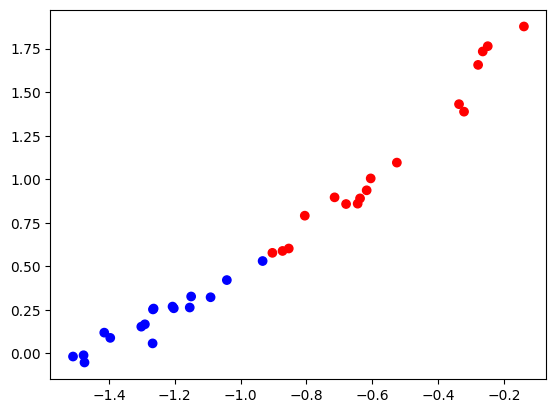

In [129]:

random_walks = []
nb_nodes = len(G.nodes())
nb_random_walks = 10
walk_length = 80
for _ in range(nb_random_walks):
    for node in G.nodes():
        random_walks.append(biased_walk(G,node,walk_length, 2, 0.5))
print(random_walks)

skip_gram = Word2Vec(random_walks,vector_size=2, window=5, workers=4, min_count=1, sg = 1 )
skip_gram.train(random_walks, total_examples=skip_gram.corpus_count, epochs=1)

node_embedding = np.array([skip_gram.wv[node] for node in G.nodes()])

plt.scatter(node_embedding[:,0],node_embedding[:,1],c=colors)

## Node Classification

Finally, we will use the learned embeddings to perform node classification. We will use a simple SVC model to classify the nodes of the graph according to their community.

Split the nodes into a training and a test set, and train a SVC model on the training set. Evaluate the model on the test set and report the accuracy for each embedding. Average the results over 10 runs.

In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to perform node classification
def node_classification(embedding, target, test_size=0.3, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(embedding, target, test_size=test_size, random_state=random_state)
    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Embeddings to compare
embeddings = {
    'Node Features': normalized_node_features_matrix,
    'Spectral Embedding': spectral_pos,
    'DeepWalk Embedding': dw_embedding,
    'Node2Vec Embedding': nv_embedding
}

# Average the results over 10 runs for each embedding
results = {}
for name, embedding in embeddings.items():
    accuracies = []
    for i in range(10):
        accuracy = node_classification(embedding, target, test_size=0.3, random_state=i)
        accuracies.append(accuracy)
    average_accuracy = np.mean(accuracies)
    results[name] = average_accuracy

# Display the results in a table
results_df = pd.DataFrame(list(results.items()), columns=['Embedding', 'Average Accuracy'])
print(results_df)

            Embedding  Average Accuracy
0       Node Features          0.409091
1  Spectral Embedding          1.000000
2  DeepWalk Embedding          0.954545
3  Node2Vec Embedding          1.000000


# Cora dataset

Repeat the same experiments on the Cora dataset, which is a citation network of machine learning papers. The goal is to classify the papers into one of seven classes. The problem should be more challenging than the previous one, as the graph is larger and more complex.

Don't hesitate to tune the hyperparameters of the embedding techniques and the SVC model to improve the results. But take care of the computational cost, as some methods can be slow on large graphs.

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='./data/Cora', name='Cora')
data = dataset[0]
cora = to_networkx(data)


In [ ]:
# 13min sur ma machine !!
n2v = Node2Vec(dimensions=32)
n2v.fit(cora)
cora_nv = n2v.get_embedding()


In [113]:
for i in range(10):
    accuracy = node_classification(cora_nv, dataset[0].y, test_size=0.3, random_state=i)
    accuracies.append(accuracy)
average_accuracy = np.mean(accuracies)
print(average_accuracy)

0.8167356219016735


NameError: name 'G' is not defined